In [1]:
!pip install torch torchvision scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
from google.colab import files
import zipfile

uploaded = files.upload()  # Upload train.zip and val.zip

for file_name in uploaded:
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall()


Saving train.zip to train.zip
Saving val.zip to val.zip


RESNET


In [3]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ImageFolder("train", transform=transform_train)
val_dataset = ImageFolder("val", transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [4]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier (fully connected layer) for binary classification
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 97.3MB/s]


In [5]:
from torch import optim
from sklearn.metrics import classification_report

criterion = nn.BCELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only train the final layer

# Training loop
for epoch in range(50):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Save model
torch.save(model.state_dict(), "resnet18_gender.pth")


Epoch 1, Loss: 24.2267
Epoch 2, Loss: 15.6464
Epoch 3, Loss: 12.8935
Epoch 4, Loss: 12.1190
Epoch 5, Loss: 11.0268
Epoch 6, Loss: 10.8423
Epoch 7, Loss: 10.2918
Epoch 8, Loss: 9.5537
Epoch 9, Loss: 10.4298
Epoch 10, Loss: 10.6898
Epoch 11, Loss: 9.4839
Epoch 12, Loss: 8.8966
Epoch 13, Loss: 9.4352
Epoch 14, Loss: 9.9902
Epoch 15, Loss: 9.5678
Epoch 16, Loss: 8.2772
Epoch 17, Loss: 8.4846
Epoch 18, Loss: 8.8394
Epoch 19, Loss: 8.5951
Epoch 20, Loss: 8.6308
Epoch 21, Loss: 7.9484
Epoch 22, Loss: 8.2319
Epoch 23, Loss: 7.9942
Epoch 24, Loss: 7.9259
Epoch 25, Loss: 8.5771
Epoch 26, Loss: 8.5783
Epoch 27, Loss: 8.5237
Epoch 28, Loss: 8.2051
Epoch 29, Loss: 8.1766
Epoch 30, Loss: 7.8254
Epoch 31, Loss: 7.6581
Epoch 32, Loss: 7.6237
Epoch 33, Loss: 7.9244
Epoch 34, Loss: 8.4282
Epoch 35, Loss: 7.6863
Epoch 36, Loss: 7.4420
Epoch 37, Loss: 7.6512
Epoch 38, Loss: 7.2425
Epoch 39, Loss: 7.6906
Epoch 40, Loss: 7.3365
Epoch 41, Loss: 7.7019
Epoch 42, Loss: 7.3322
Epoch 43, Loss: 7.2296
Epoch 44, L

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (outputs.cpu().numpy() > 0.5).astype(int).flatten()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

print("== Evaluation on val/ set ==")
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:   ", recall_score(y_true, y_pred))
print("F1-score: ", f1_score(y_true, y_pred))


== Evaluation on val/ set ==
Accuracy:  0.9004739336492891
Precision: 0.923943661971831
Recall:    0.956268221574344
F1-score:  0.9398280802292264


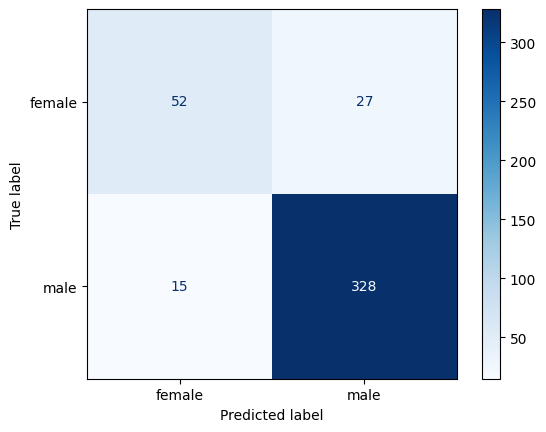

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['female', 'male'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [10]:
import json

# Step 1: Compute metrics
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)

# Step 2: Create dictionary
results = {
    "accuracy":  round(accuracy, 4),
    "precision": round(precision, 4),
    "recall":    round(recall, 4),
    "f1_score":  round(f1, 4)
}

# Step 3: Save as JSON
with open("results_task_a.json", "w") as f:
    json.dump(results, f, indent=4)

print("✅ Saved evaluation metrics to results_task_a.json")


✅ Saved evaluation metrics to results_task_a.json


In [11]:
!ls

resnet18_gender.pth  results_task_b.json  train      val
results_task_a.json  sample_data	  train.zip  val.zip
